<center>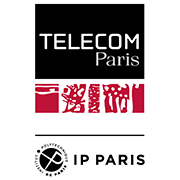</center>

<h1><center><strong><font color="green">IA 717: Linguistic Differences of Human-Human and AI-Generated Conversations</font></strong></center></h1>
<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor <br/> <a>Yi YU</a></h3>
<email>yi.yu@inria.fr</email>
<br/>

Year 2025-2026
</center>

------------------------

# <font color="green">**Context & Objectives**</font>

> The application of large language models (LLMs) in dialogue-based scenarios has become part of daily life since 2023. Human-LLM corpora are now available and enable the study on differences between Human-Human conversations and those generated by LLMs. The differences between these conversations can provide insights into potential alignment direction for current LLM-based chatbot with human expectations.

The objective of this project is to study the linguistic difference between two chosen corpora, <a href="https://github.com/facebookresearch/EmpatheticDialogues">EmpathicDialogues</a> and <a href="https://github.com/morganlee123/2GPTEmpathicDialogues">2GPTEmpathicDialogues</a>. The second is created as a replica of the first one by prompting two independent instances of ChatGPT. 

The following image provides an example of two conversations genereated under the same scenario, one by human, the other by ChatGPT.
![image.png](https://github.com/morganlee123/2GPTEmpathicDialogues/blob/main/paperfigures/exampledialogue.png?raw=true) 

We will first start with an exploration of basic concepts for conversation analysis (e.g. nb of turns per conversation, avg words per turn, etc.) and understand what has been studied within these two corpora in <a href="https://arxiv.org/abs/2401.16587">this paper</a>. We will then compare these two corpora on our own, focusing on one linguistic feature for affect study introduced later and calculate it for each conversation.

1) explore the mentioned corpora
2) analyze the general information about each corpus: the size of corpus and the setting used for the corpus creation 
3) study one linguistic feature for collaborative state analysis, <a href="https://www.liwc.app/help/lsm">language style matching</a>, calculate it for each pair of participants, human or ChatGPT, and finally compare the level of matching between two corpora
4) build a baseline model for LLM-generated dialogue detection using only word embedding as feature
5) add the calculated feature from step <a>3</a> to your baseline model to see if there is any improvement in performance
6) highlight your findings during the experiment


### <font color="green">Evaluation</font>

The project is evaluated through a presentation with a report and your completed project. Grades will be partly individual and partly collective. 

# <font color="green">**1 & 2 - Data Retrieval & Analysis**</font>

We need to download the two mentioned corpora using the link provided earlier. Each conversation in EmpatheticDialogue should be paired with a conversation in 2GPTEmpathicDialogues. Check if any conversation cannot be paired

<font color="red"> 1.1 Question: </font>  
Preprocessing and Data Exploration — Answer the following:

- How many conversations in EmpatheticDialogue can be paired with those in 2GPTEmpathicDialogues?  
- What is the average number of turns per conversation in each corpus?  
- What is the average number of words per conversation in both corpora?  
- How are conversations distributed across different emotional contexts (e.g., annoyed, proud, furious)?  

Present your findings using appropriate graphs and visualizations where possible.

<font color="orange">1.1 Answer:</font> 

In [54]:
# imports
import pandas as pd
import numpy as np
import os

# read data
dial_GPT = pd.read_csv('../data/GPT_dial/2GPTEmpathicDialoguesDataset.csv')
dial_human_train = pd.read_csv('../data/empatheticdialogues/train.csv',quoting=3)

# describe data
dial_human_train.info()
print("\n")
dial_GPT.info()

# Problèmes:
# - les fichiers valid et test du dialogue humain ont des champs en trop. On décide de supprimer ces champs en trop (',,') pour pour pouvoir les lire
# Solution:
# - on concatène les trois fichiers: valid/test/train du dialogue humain
# - on décide également de supprimer les champs jugés non pertinents dans les fichiers humains (derniers champs). On ne garde que les 6 premières colonnes (0 à 5)

df_valid_human = pd.read_csv(
    "../data/empatheticdialogues/valid.csv",
    usecols=range(6),
    engine="python",
    on_bad_lines="skip",      # saute les lignes trop foireuses
    quoting=3                 # 3 = csv.QUOTE_NONE → ignore les guillemets
)

df_test_human = pd.read_csv(
    "../data/empatheticdialogues/test.csv",
    usecols=range(6),
    engine="python",
    on_bad_lines="skip",   # saute les lignes corrompues
    quoting=3              # ignore les guillemets
)
human_dial = pd.concat([df_valid_human, df_test_human, dial_human_train])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84169 entries, 0 to 84168
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   conv_id        84169 non-null  object
 1   utterance_idx  84169 non-null  int64 
 2   context        84169 non-null  object
 3   prompt         84169 non-null  object
 4   speaker_idx    84169 non-null  int64 
 5   utterance      84169 non-null  object
 6   selfeval       84169 non-null  object
 7   tags           755 non-null    object
dtypes: int64(2), object(6)
memory usage: 5.1+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19533 entries, 0 to 19532
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19533 non-null  int64 
 1   conv_id     19533 non-null  object
 2   context     19533 non-null  object
 3   prompt      19533 non-null  object
 4   gptgen      19533 non-null  object
 5   processed   19533

In [55]:
# Construction des données:
# Deux attributs permettent de définir la structure du dialogue humain:
# - conv Id : il indique le paquet de bulles
# - uturance Id qui indique la position de la bulle dans le paquet de bulles (conv Id)

# Ces attributs n'existent pas dans le dialogue GPT. Le terme GPTgen rassemble ces deux parties (conv Id et uturance Id). Il faut donc spliter GPTgen en deux
# parties. Je vais donc devoir construire des attribut Id à partir de GPgen et pour chaque conv Id
# Comparaison de processed et GptGen: on a la même information (chaine de string avec les dialogues associés). Dans lprocessed, nous n'avons cependant pas l'identificatino 
# des speakers. La création de l'attribut ID va donc être plus facile avec processed qu'avec GPTgen, puisqu'on va utiliser le retour chariot pour créer l'attribut ID suivant.
# Remarque importante: on va construire un attribut ID pour les deux (human et GPT). L'attribut Id de human sera donc modifié.


# Après avoir créé les attribut_id pour GPT, on se rend compte chaque tour par quatre balises différentes possibles: speaker/listener/assistant1/assistant2.
# On se pose la question de savoir s'il faut retenir attribut 1/attribut 2 et/ou speaker/listener.
# L'étude du code nous montre qu'il existe deux GPT qui essaient de converser : attribut 1 et attribut 2.
# Problème: dans certains cas, le GPT se retrouve à être speaker puis à enchainer en étant listener, puis speaker ... avant d'être interrompu par le deuxième GPT et changer d'assitant.
# On remarque également que la séparation listener/speaker au sein d'un même tour attribut est séparé par un double retour chariot (/n/n) alors que la séparation
# attribut 1/attribut2 est faite par un simple /n.

# Choix faits: on décide que les monologues listener/speaker générés pas un GPT ont du sens linguistique. On décide donc de les garder. 
# Il subsiste cependant une interrogation sur la gestion des éléments tronqués:
# - assistant qui a coupé la parole qui commence à parler avec une phrase tronquée qui commence par une ponctuation, minuscule ...
# - assistant qui a la parole coupée qui ne termine pas sa phrase.
# Dans ces deux cas, les phrases n'ont pas de sens. 
# Problématique de ces interventions tronquées:
# - elles n'ont pas de sens linguistique;
# - on a un enchaninement assistant 1 (speaker) -> assistant 2 (speaker)
# On a donc l'enchainement de speaker/speaker ou listener/listener qui font perdre l'alternance logique speaker/listener.




 

In [56]:
# on travaille sur gpt_dial
dial_GPT.head()

,Unnamed: 0,conv_id,context,prompt,gptgen,processed
0,0,hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,assistant1: I know exactly what you mean. Ther...,i know exactly what you mean. there's somethi...
1,1,hit:10000_conv:20000,surprised,My girlfriend got me a toad today! I was so sh...,assistant1: That's amazing! How did she know y...,that's amazing! how did she know you wanted a...
2,2,hit:10000_conv:20001,impressed,I really like the new paint job on my house.,"assistant1: Listener: Hey, have you seen the n...","hey, have you seen the new paint job on my h..."
3,3,hit:10001_conv:20002,lonely,I went to the skating rink all by myself today...,"assistant1: Listener: Hey, how's it going?\n\n...","hey, how's it going?\n\n hey there. i'm feel..."
4,4,hit:10002_conv:20004,ashamed,I was walking on the road. I saw beggar and i ...,"assistant1: Speaker: Hey, I need to get someth...","hey, i need to get something off my chest. i..."


In [57]:

# création d'une liste intermédiaire à partir de la colonne 'gptgen' du dataframe dial_GPT
# On suppose que chaque dialogue est séparé par un retour à la ligne
print(dial_GPT['processed'][0])


 i know exactly what you mean. there's something magical about being surrounded by a crowd of people, yet feeling like it's just you and your best friend in that moment. it's as if time stands still, and all that matters is the bond you share.
 that sounds like such a special and beautiful experience. it's amazing how certain moments can make us feel so connected and close to someone, even in the midst of a crowd. it's like the world fades away and all that matters is the deep connection between you and your best friend.
 absolutely, it truly was a special and beautiful experience. you're right, those moments when it feels like the world fades away and all that matters is the connection between you and your best friend are truly magical. it's like time stands still and all the noise and distractions around us just disappear. it's in those moments that we realize how much we mean to each other and how fortunate we are to have such a strong bond.
 i completely understand what you're sayi

In [58]:
# Séparer les dialogues (bulles) en faisant un retour chariot 
dial_GPT['processed']=dial_GPT['processed'].str.split("\n")
print(dial_GPT['processed'][0])

# explode
dial_GPT2=dial_GPT.explode('processed')
dial_GPT2 = dial_GPT2[dial_GPT2['processed'] != ""] # suppression des dialogues vides
dial_GPT2['utterance_idx']=dial_GPT2.groupby('conv_id').cumcount()+1

# merge des deux df
dial_merge = pd.merge(dial_GPT2,human_dial,on=['conv_id','utterance_idx'],how='outer')
print(f'le nombre de conversations communes:',len(set(dial_GPT2['conv_id']).intersection(set(human_dial['conv_id']))))


[" i know exactly what you mean. there's something magical about being surrounded by a crowd of people, yet feeling like it's just you and your best friend in that moment. it's as if time stands still, and all that matters is the bond you share.", " that sounds like such a special and beautiful experience. it's amazing how certain moments can make us feel so connected and close to someone, even in the midst of a crowd. it's like the world fades away and all that matters is the deep connection between you and your best friend.", " absolutely, it truly was a special and beautiful experience. you're right, those moments when it feels like the world fades away and all that matters is the connection between you and your best friend are truly magical. it's like time stands still and all the noise and distractions around us just disappear. it's in those moments that we realize how much we mean to each other and how fortunate we are to have such a strong bond.", " i completely understand what 

In [59]:
dial_GPT2.head(2)


,Unnamed: 0,conv_id,context,prompt,gptgen,processed,utterance_idx
0,0,hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,assistant1: I know exactly what you mean. Ther...,i know exactly what you mean. there's somethi...,1
0,0,hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,assistant1: I know exactly what you mean. Ther...,that sounds like such a special and beautiful...,2


In [60]:
# compte de tours par conversations (human et GPT) - nombre d'uturance dans chaque conv_id
# GPT
utterance_GPT_count = dial_GPT2.groupby('conv_id')['utterance_idx'].count().mean()
utterance_human_count = human_dial.groupby('conv_id')['utterance_idx'].count().mean()

print(f'moyenne d utterance human_dial: {utterance_human_count:.2f}')
print(f'moyenne d utterance GPT_dial :{utterance_GPT_count:.2f}')

# moyenne des mots dans chaque utterance
words_GPT_count = dial_GPT2['processed'].str.split().str.len().mean()
word_human_count = human_dial['utterance'].str.split().str.len().mean()

print(f'moyenne de mots par utterance human_dial : {word_human_count:.2f}')
print(f'moyenne de mots par utterance GPT_dial: {words_GPT_count:.2f}')


moyenne d utterance human_dial: 4.31
moyenne d utterance GPT_dial :8.24
moyenne de mots par utterance human_dial : 13.71
moyenne de mots par utterance GPT_dial: 36.42


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31],
 [Text(0, 0, 'surprised'),
  Text(1, 0, 'excited'),
  Text(2, 0, 'terrified'),
  Text(3, 0, 'angry'),
  Text(4, 0, 'annoyed'),
  Text(5, 0, 'afraid'),
  Text(6, 0, 'furious'),
  Text(7, 0, 'proud'),
  Text(8, 0, 'prepared'),
  Text(9, 0, 'nostalgic'),
  Text(10, 0, 'joyful'),
  Text(11, 0, 'sad'),
  Text(12, 0, 'grateful'),
  Text(13, 0, 'jealous'),
  Text(14, 0, 'hopeful'),
  Text(15, 0, 'anxious'),
  Text(16, 0, 'confident'),
  Text(17, 0, 'lonely'),
  Text(18, 0, 'anticipating'),
  Text(19, 0, 'disappointed'),
  Text(20, 0, 'embarrassed'),
  Text(21, 0, 'disgusted'),
  Text(22, 0, 'devastated'),
  Text(23, 0, 'caring'),
  Text(24, 0, 'trusting'),
  Text(25, 0, 'ashamed'),
  Text(26, 0, 'apprehensive'),
  Text(27, 0, 'content'),
  Text(28, 0, 'impressed'),
  Text(29, 0, 'guilty'),
  Text(30, 0, 'sentimen

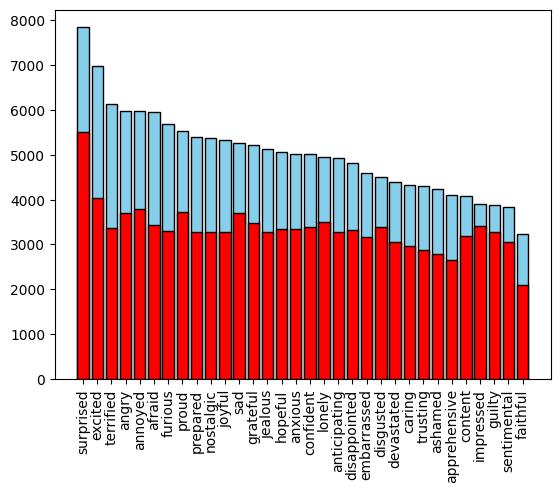

In [61]:
import matplotlib.pyplot as plt

# répartition par contexte dial GPT
context_counts_GPT = dial_GPT2['context'].value_counts() # calcule le nombre d'occurence de chaque contexte
bars = plt.bar(context_counts_GPT.index, context_counts_GPT.values, color='skyblue', edgecolor='black')

# répartition du contexte dial human
context_counts_human = human_dial['context'].value_counts()
bars = plt.bar(context_counts_human.index,context_counts_human.values,edgecolor='black',color='red')
plt.xticks(rotation=90)

<font color="red">1.2 Question:</font> Summarize your findings during the preprocessing process. Do you think we should include all the available contexts for our study? Why? 'Context' here refer to a column name in EmpatheticDialogue csv file.

<font color="orange">1.2 Answer:</font> 

In [62]:
# To-do


<font color="red">2.1 Question:</font> Understand the prompting design used in 2GPTEmpathicDialogue generation. What are the advantages and limitations of this setting?

<font color="orange">2.1 Answer:</font> 

In [63]:
# # Après avoir créé les attribut_id pour GPT, on se rend compte chaque tour par quatre balises différentes possibles: speaker/listener/assistant1/assistant2.
# On se pose la question de savoir s'il faut retenir attribut 1/attribut 2 et/ou speaker/listener.
# L'étude du code nous montre qu'il existe deux GPT qui essaient de converser : attribut 1 et attribut 2.
# Problème: dans certains cas, le GPT se retrouve à être speaker puis à enchainer en étant listener, puis speaker ... avant d'être interrompu par le deuxième GPT et changer d'assitant.
# On remarque également que la séparation listener/speaker au sein d'un même tour attribut est séparé par un double retour chariot (/n/n) alors que la séparation
# attribut 1/attribut2 est faite par un simple /n.

# Choix faits: on décide que les monologues listener/speaker générés pas un GPT ont du sens linguistique. On décide donc de les garder. 
# Il subsiste cependant une interrogation sur la gestion des éléments tronqués:
# - assistant qui a coupé la parole qui commence à parler avec une phrase tronquée qui commence par une ponctuation, minuscule ...
# - assistant qui a la parole coupée qui ne termine pas sa phrase.
# Dans ces deux cas, les phrases n'ont pas de sens. 
# Problématique de ces interventions tronquées:
# - elles n'ont pas de sens linguistique;
# - on a un enchaninement assistant 1 (speaker) -> assistant 2 (speaker)
# On a donc l'enchainement de speaker/speaker ou listener/listener qui font perdre l'alternance logique speaker/listener.


# <font color="green">**3 - Linguistic Feature for the Affective State between Participants**</font>

LSM is a linguistic feature related to affect analysis. You can add more as you like. You need to make sure each of your choice is supported by at least one published paper since the references are required. You need to check how to calculate each of the feature using dialogue text.

<font color="red">3.0 Question:</font> What is the affect analysis? What are possible scenario/application for affect analysis?

<font color="orange">3.0 Answer:</font> 

In [64]:
# L'analyse de affects est une méthode d’évaluation automatique des émotions et des sentiments exprimés dans un texte, un discours, une image ou même une vidéo.
# Elle cherche à déterminer l’état émotionnel d’une personne à partir de son langage ou de ses comportements.
# utilisations possibles : psychologie/Marketing/Intelligence artificielle...

<font color="red">3.1 Question:</font> How can the selected linguistic features be implemented for affective state analysis? If you use any open-source libraries or tools, please specify them and reference them in your code.

<font color="orange">3.1 Answer:</font> 

In [65]:
# L’analyse des états affectifs consiste à détecter les émotions ou sentiments exprimés dans un texte à partir de caractéristiques linguistiques: ces caractéristiques peuvent proenir du lexique, 
# de la synthaxe, de la sémantique ...
# Bibliothèque possible: NLTK et VADER

<font color="red">3.2 Question:</font> Is affective state impacted by scenario setting? What are the scenario that achieve highest affective state between human participants? Does ChatGPT generated conversation share the same answer?

<font color="orange">3.2 Answer:</font> 

In [66]:
# import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# from nltk.stem import WordNetLemmatizer
# import spacy

# import os
# nlp = spacy.load("en_core_web_sm")
# n_cpus = os.cpu_count()
# print(f"Using {n_cpus} CPU cores")

# texts = human_dial['utterance'].tolist()
# docs = list(nlp.pipe(texts, n_process=n_cpus - 1))  # ici la parallélisation est activée

# # Récupérer les tokens et leurs POS
# human_dial['utterance_tag_POS'] = [[(token.text, token.pos_) for token in doc] for doc in docs]

# # création d'un dictionnaire de mapping

# # associer chaque token à une catégorie de LSM

# CATEGORIES = {
#     "pronouns": ["PRON"],
#     "articles": ["DET"],
#     "prepositions": ["ADP"],
#     "aux_verbs": ["AUX", "VERB"],
#     "adverbs": ["ADV"],
#     "conjunctions": ["CCONJ"],
#     "negations": ["ADV"],  # + filtre lexical
# }

# def map_pos_to_category(tag, word):
#     for cat, tags in CATEGORIES.items():
#         if tag in tags:
#             # Cas particulier : la catégorie "negations" ne s'applique
#             # que si le mot est bien une négation connue
#             if cat == "negations" and word not in ["no", "not", "never", "n't"]:
#                 continue
#             return cat
#     return None

# def categorize_tokens(tagged_tokens):
#     categorized = []
#     for word, pos in tagged_tokens:
#         cat = map_pos_to_category(pos, word)
#         categorized.append((word, pos, cat))
#     return categorized

# human_dial['utterance_tag_POS_cat']=human_dial['utterance_tag_POS'].apply(categorize_tokens)

# # compter les occurences de chaque catégorie
# def count_categories(tagged_list):
#     counts = {}
#     for _, _, cat in tagged_list:
#         if cat:
#             counts[cat] = counts.get(cat, 0) + 1
#     return counts

# human_dial['utterance_lsm_counts'] = human_dial['utterance_tag_POS_cat'].apply(count_categories)

# # mettre utterance_lsm_count sous forme de colonne
# human_dial_cat = pd.json_normalize(human_dial['utterance_lsm_counts'])
# human_dial_cat = human_dial_cat.fillna(0).add_prefix('lsm_')

# # concaténer human_dial avec human_dial_cat
# human_dial = human_dial.reset_index(drop=True)
# human_dial_cat = human_dial_cat.reset_index(drop=True)

# human_dial = pd.concat([human_dial, human_dial_cat], axis=1)

# # compte de la longueur de token sur chaque ligne
# human_dial['len_token_utterance'] = human_dial['utterance_tag_POS'].apply(len)
# # normalisation des colonnes catégorielles
#     # sélection des colonnes
# lsm_cols=[col for col in human_dial.columns if col.startswith('lsm_')]
#     # normalisation des colonnes
# human_dial[lsm_cols]=human_dial[lsm_cols].div(human_dial['len_token_utterance'],axis=0)


# #création de speaker
# human_dial['speaker']=np.where(human_dial['utterance_idx']%2==0,'speaker A','speaker B')

# # moyenne par speaker
#     # sélection des colonnes catégories
# lsm_col = [col for col in human_dial.columns if col.startswith('lsm_')]
# speakers_huma_mean = human_dial.groupby('speaker')[lsm_col].mean()
# #print(speakers_huma_mean)

# # calcul des moyennes globales
# speaker_human_LSM_mean_mean = speakers_huma_mean.mean(axis=1)


In [67]:
dial_GPT2.head()


,Unnamed: 0,conv_id,context,prompt,gptgen,processed,utterance_idx
0,0,hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,assistant1: I know exactly what you mean. Ther...,i know exactly what you mean. there's somethi...,1
0,0,hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,assistant1: I know exactly what you mean. Ther...,that sounds like such a special and beautiful...,2
0,0,hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,assistant1: I know exactly what you mean. Ther...,"absolutely, it truly was a special and beauti...",3
0,0,hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,assistant1: I know exactly what you mean. Ther...,i completely understand what you're saying. i...,4
1,1,hit:10000_conv:20000,surprised,My girlfriend got me a toad today! I was so sh...,assistant1: That's amazing! How did she know y...,that's amazing! how did she know you wanted a...,1


In [68]:
# text_GPT = dial_GPT2['processed'].tolist()
# docs_GPT = list(nlp.pipe(text_GPT, n_process=n_cpus - 1))  # ici la parallélisation est activée

# # Récupérer les tokens et leurs POS
# dial_GPT2['utterance_tag_POS'] = [[(token.text, token.pos_) for token in doc] for doc in docs]

# # création d'un dictionnaire de mapping

# # associer chaque token à une catégorie de LSM

# CATEGORIES = {
#     "pronouns": ["PRON"],
#     "articles": ["DET"],
#     "prepositions": ["ADP"],
#     "aux_verbs": ["AUX", "VERB"],
#     "adverbs": ["ADV"],
#     "conjunctions": ["CCONJ"],
#     "negations": ["ADV"],  # + filtre lexical
# }

# def map_pos_to_category(tag, word):
#     for cat, tags in CATEGORIES.items():
#         if tag in tags:
#             # Cas particulier : la catégorie "negations" ne s'applique
#             # que si le mot est bien une négation connue
#             if cat == "negations" and word not in ["no", "not", "never", "n't"]:
#                 continue
#             return cat
#     return None

# def categorize_tokens(tagged_tokens):
#     categorized = []
#     for word, pos in tagged_tokens:
#         cat = map_pos_to_category(pos, word)
#         categorized.append((word, pos, cat))
#     return categorized

# dial_GPT2['utterance_tag_POS_cat']=dial_GPT2['utterance_tag_POS'].apply(categorize_tokens)

# # compter les occurences de chaque catégorie
# def count_categories(tagged_list):
#     counts = {}
#     for _, _, cat in tagged_list:
#         if cat:
#             counts[cat] = counts.get(cat, 0) + 1
#     return counts

# dial_GPT2['utterance_lsm_counts'] = dial_GPT2['utterance_tag_POS_cat'].apply(count_categories)

# # mettre utterance_lsm_count sous forme de colonne
# dial_GPT2_cat = pd.json_normalize(dial_GPT2['utterance_lsm_counts'])
# dial_GPT2_cat = dial_GPT2_cat.fillna(0).add_prefix('lsm_')

# # concaténer human_dial avec human_dial_cat
# dial_GPT2 = dial_GPT2.reset_index(drop=True)
# dial_GPT2_cat = dial_GPT2_cat.reset_index(drop=True)

# dial_GPT2 = pd.concat([dial_GPT2, dial_GPT2_cat], axis=1)

# # compte de la longueur de token sur chaque ligne
# dial_GPT2['len_token_utterance'] = dial_GPT2['utterance_tag_POS'].apply(len)
# # normalisation des colonnes catégorielles
#     # sélection des colonnes
# lsm_cols=[col for col in dial_GPT2.columns if col.startswith('lsm_')]
#     # normalisation des colonnes
# dial_GPT2[lsm_cols]=dial_GPT2[lsm_cols].div(dial_GPT2['len_token_utterance'],axis=0)


# #création de speaker
# dial_GPT2['speaker']=np.where(dial_GPT2['utterance_idx']%2==0,'speaker A','speaker B')

# # moyenne par speaker
#     # sélection des colonnes catégories
# lsm_col = [col for col in dial_GPT2.columns if col.startswith('lsm_')]
# speakers_GPT_mean = dial_GPT2.groupby('speaker')[lsm_col].mean()
# #print(speakers_huma_mean)

# # calcul des moyennes globales
# speaker_GPT_LSM_mean_mean = speakers_GPT_mean.mean(axis=1)


<font color="red">3.3 Question:</font> What are scenarios selected for this project? Why? 

<font color="orange">3.3 Answer:</font> 

# <font color="green">**4 - Modeling for ChatGPT-Generated Dialogue Detection**</font>

Our first baseline model can be defined since two corpora provide naturally labeled conversations.  

<font color="red">4.1 Question:</font> Which word embedding model is used by the paper? Why? Which word embedding model will you use? 

You can test several word embedding model and choos the one give you the best performance GPT generated dialogue classification.

<font color="orange">4.1 Answer:</font> 

In [69]:
# Modèle d’embedding utilisé : text-embedding-ada-002
# Fournisseur : OpenAI
# Type de modèle : modèle de Transformers préentraîné sur de grandes quantités de texte (multilingue, contextuel)
# Rôle : générer des représentations vectorielles de phrases ou dialogues qui capturent le sens global et le ton affectif du texte.
# 
# Pourquoi ce choix :
# C’est un modèle généraliste, performant et facilement accessible via l’API OpenAI.
# Il produit des embeddings contextuels (chaque mot ou phrase est compris selon le sens du texte complet).
# Il est léger, rapide et très efficace pour les comparaisons sémantiques, les classifications et les analyses affectives.

# La réponse se trouve à la page 9 du rapport universitaire de A Linguistic Comparison between Human and ChatGPT-Generated Conversations

<font color="red">4.2 Question:</font> How to define the binary classification task? Test both linear and non-linear models to see which model provide better performance? You can follow the test, train, valid seperation defined inside Empatheticdiaogues corpus.

<font color="orange">4.2 Answer:</font> 

<font color="red">4.3 Question:</font> What metrics do you use to evaluate your model's performance? What is the performance of your baseline model? In which scenario does your model achieve the best performance?Present the performance using appropriate graphs and visualizations where possible. 

<font color="orange">4.3 Answer:</font> 

In [70]:
human_dial.head()
human_dial_merge_ut_id = human_dial.groupby('conv_id')['utterance'].apply(''.join).reset_index()
human_dial_merge_ut_id.set_index('conv_id')
human_dial_merge_ut_id['variable']=0

dial_GPT['processed'] = dial_GPT['processed'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
dial_GPT_merge_ut_id = dial_GPT.groupby('conv_id')['processed'].apply(''.join).reset_index()
dial_GPT_merge_ut_id.rename(columns={'processed': 'utterance'}, inplace=True)
dial_GPT_merge_ut_id['variable'] = 1

dial_emb_GPT_human = pd.concat([dial_GPT_merge_ut_id,human_dial_merge_ut_id])


print(f'longueur dial dial_GPT_merge_ut_id : {dial_GPT_merge_ut_id.shape[0]}')
print(f'longueur dial human_dial_merge_ut_id : {human_dial_merge_ut_id.shape[0]}')
print(f'longueur dial dial_emb_GPT_human : {dial_emb_GPT_human.shape[0]}')
dial_emb_GPT_human.tail()


longueur dial dial_GPT_merge_ut_id : 19533
longueur dial human_dial_merge_ut_id : 24850
longueur dial dial_emb_GPT_human : 44383


,conv_id,utterance,variable
24845,hit:999_conv:1999,I was shocked when Lebron left the cavs again!...,0
24846,hit:99_conv:198,I cheated on a test. I am very ashamed.oh no :...,0
24847,hit:99_conv:199,my husband lost a job but i'm hoping he can fi...,0
24848,hit:9_conv:18,HelloHi_comma_ how are you?Im doing great i ju...,0
24849,hit:9_conv:19,Once when I was in preschool_comma_ my pants f...,0


In [71]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("all-MiniLM-L6-v2")

# print(dial_emb_GPT_human.head())
# print(dial_emb_GPT_human.columns)
# print(dial_emb_GPT_human['utterance'].isna().sum(), "NA dans utterance")
# print(dial_emb_GPT_human['variable'].isna().sum(), "NA dans variable")

In [72]:
# from sklearn.linear_model import LogisticRegression

# X = model.encode(dial_emb_GPT_human['utterance'])
# y = np.array(dial_emb_GPT_human['variable'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# clf = LogisticRegression(max_iter=1000)
# clf.fit(X_train, y_train)



In [73]:

# Valence vs arousal:
# valence: détermine l'émotion
# arousal: détermine l'excitation       => ces deux données sont dans emotions de elfen

# elfen -> fait une tokenisation/associe à chaque mot une valence et une arousal.
# plutôt que de concaténer chaque utterance de chaque id, je vais scorer chaque utterance, puis agréger par conv_id. Comme ça ma moyenne de valence et arousal sera moins sensible à la longueur de conv_id 

# je vais ensuite entrainer un modèle linéaire en faisant un train_test.split/fit/predict avec:
# - Y (label) = 0 (GPT) ou 1 (human)
# - X (features) = valence_avg et arousal_avg
# But: prédir si le conv_id est GPT ou human


In [74]:
import polars as pl
from elfen.extractor import Extractor

# extraction des données
dial_human3 = human_dial.copy() 
dial_human3.head(10)


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:3_conv:6,1,terrified,Today_comma_as i was leaving for work in the m...,6,Today_comma_as i was leaving for work in the m...,NaN,NaN
1,hit:3_conv:6,2,terrified,Today_comma_as i was leaving for work in the m...,7,Are you fine now?,NaN,NaN
2,hit:3_conv:6,3,terrified,Today_comma_as i was leaving for work in the m...,6,Yeah_comma_i'm doing alright now_comma_ but wi...,NaN,NaN
3,hit:3_conv:6,4,terrified,Today_comma_as i was leaving for work in the m...,7,Cool :) Is your car damaged a lot?,NaN,NaN
4,hit:3_conv:6,5,terrified,Today_comma_as i was leaving for work in the m...,6,The car was badly damaged_comma_i veered outsi...,NaN,NaN
5,hit:4_conv:9,1,surprised,I was walking through my hallway a few week ag...,8,A few weeks ago_comma_ I was walking through m...,NaN,NaN
6,hit:4_conv:9,2,surprised,I was walking through my hallway a few week ag...,4,That's funny_comma_ hope he didn't give you a ...,NaN,NaN
7,hit:4_conv:9,3,surprised,I was walking through my hallway a few week ag...,8,I may have let out a scream that will have him...,NaN,NaN
8,hit:4_conv:9,4,surprised,I was walking through my hallway a few week ag...,4,I would probably scream also.,NaN,NaN
9,hit:6_conv:12,1,excited,I'm overly excited today because will be flyin...,6,I'm overly excited because will be flying outs...,NaN,NaN


In [75]:
# #-------------------------------------------------#
# #CODE POUR EXTRAIRE LES EMOTIONS DE GPT AVEC ELFEN 
# #-------------------------------------------------#

# import polars as pl
# from elfen.extractor import Extractor
# import os
# import multiprocessing

# # --- Multithreading CPU ---
# nb_cores = multiprocessing.cpu_count()     # détecte le nombre total de cœurs
# n_used = min(nb_cores, 8)                  # limite à 8 pour stabilité macOS ARM

# for var in ["OMP_NUM_THREADS", "OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS", "VECLIB_MAXIMUM_THREADS"]:
#     os.environ[var] = str(n_used)

# print(f"ELFEN utilisera {n_used}/{nb_cores} cœurs logiques disponibles.")

# dial_GPT3 = dial_GPT2.copy()        # dial_GPT2 est dial_GPT avec utterance_idx (question 1)
# dial_GPT3 = dial_GPT3.rename({'processed': 'text'}, axis=1)

# # Convertir en Polars
# dial_GPT3 = pl.DataFrame(dial_GPT3)


# # création de l'extracteur de GPT
# extracteur_GPT = Extractor(
#     data=dial_GPT3,
#     text_col="text",
#     lang="en",              # langue anglaise
#     model="en_core_web_sm"  #modèle qui sera utilisé : ici Spacy
# )
# #extraction du groupe "emotion"
# extracteur_GPT.extract_feature_group("emotion")

# # Récupérer les colonnes ajoutées directement dans ext.data
# extraction_GPT = extracteur_GPT.data.select([
#     "conv_id",
#     "utterance_idx",
#     "text",
#     "avg_valence",   
#     "avg_arousal"        
# ])
# # sauvegarde des données en csv
# extraction_GPT.write_csv("../data/GPT_valence_scores/GPT_valence_scores.csv")



In [76]:
dial_human3 = human_dial.copy() 
dial_human3 = dial_human3.rename({'utterance': 'text'}, axis=1)
dial_human3.head(10)

,conv_id,utterance_idx,context,prompt,speaker_idx,text,selfeval,tags
0,hit:3_conv:6,1,terrified,Today_comma_as i was leaving for work in the m...,6,Today_comma_as i was leaving for work in the m...,NaN,NaN
1,hit:3_conv:6,2,terrified,Today_comma_as i was leaving for work in the m...,7,Are you fine now?,NaN,NaN
2,hit:3_conv:6,3,terrified,Today_comma_as i was leaving for work in the m...,6,Yeah_comma_i'm doing alright now_comma_ but wi...,NaN,NaN
3,hit:3_conv:6,4,terrified,Today_comma_as i was leaving for work in the m...,7,Cool :) Is your car damaged a lot?,NaN,NaN
4,hit:3_conv:6,5,terrified,Today_comma_as i was leaving for work in the m...,6,The car was badly damaged_comma_i veered outsi...,NaN,NaN
5,hit:4_conv:9,1,surprised,I was walking through my hallway a few week ag...,8,A few weeks ago_comma_ I was walking through m...,NaN,NaN
6,hit:4_conv:9,2,surprised,I was walking through my hallway a few week ag...,4,That's funny_comma_ hope he didn't give you a ...,NaN,NaN
7,hit:4_conv:9,3,surprised,I was walking through my hallway a few week ag...,8,I may have let out a scream that will have him...,NaN,NaN
8,hit:4_conv:9,4,surprised,I was walking through my hallway a few week ag...,4,I would probably scream also.,NaN,NaN
9,hit:6_conv:12,1,excited,I'm overly excited today because will be flyin...,6,I'm overly excited because will be flying outs...,NaN,NaN


In [77]:
# #-------------------------------------------------#
# #CODE POUR EXTRAIRE LES EMOTIONS DE HUMAN AVEC ELFEN 
# #-------------------------------------------------#

# # --- Multithreading CPU ---
# nb_cores = multiprocessing.cpu_count()     # détecte le nombre total de cœurs
# n_used = min(nb_cores, 8)                  # limite à 8 pour stabilité macOS ARM

# for var in ["OMP_NUM_THREADS", "OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS", "VECLIB_MAXIMUM_THREADS"]:
#     os.environ[var] = str(n_used)

# print(f" ELFEN utilisera {n_used}/{nb_cores} cœurs logiques disponibles.")

# # Convertir en Polars
# dial_human3 = pl.DataFrame(dial_human3)


# # création de l'extracteur de GPT
# extracteur_human = Extractor(
#     data=dial_human3,
#     text_col="text",
#     lang="en",              # langue anglaise
#     model="en_core_web_sm"  #modèle qui sera utilisé : ici Spacy
# )
# #extraction du groupe "emotion"
# extracteur_human.extract_feature_group("emotion")


# # sauvegarde des données en csv
# output_path = "../data/human_valence_scores/human_valence_scores_raw.parquet"
# extracteur_human.data.write_parquet(output_path)


In [ ]:
df_shak = pd.read_csv("../data/shakespeare_clean.csv")
df_shak = df_shak.rename({'utterance': 'text'}, axis=1)

#-------------------------------------------------#
#CODE POUR EXTRAIRE LES EMOTIONS DE SHAKESPEARE AVEC ELFEN 
#-------------------------------------------------#

import polars as pl
from elfen.extractor import Extractor
import os
import multiprocessing

# --- Multithreading CPU ---
nb_cores = multiprocessing.cpu_count()     # détecte le nombre total de cœurs
n_used = min(nb_cores, 8)                  # limite à 8 pour stabilité macOS ARM

for var in ["OMP_NUM_THREADS", "OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS", "VECLIB_MAXIMUM_THREADS"]:
    os.environ[var] = str(n_used)

print(f" ELFEN utilisera {n_used}/{nb_cores} cœurs logiques disponibles.")

# Convertir en Polars
df_shak = pl.DataFrame(df_shak)


# création de l'extracteur de Shakespeare
extracteur_shak = Extractor(
    data=df_shak,
    text_col="text",
    lang="en",              # langue anglaise
    model="en_core_web_sm"  #modèle qui sera utilisé : ici Spacy
)
#extraction du groupe "emotion"
extracteur_shak.extract_feature_group("emotion")


extracteur_shak.data.to_pandas().to_csv(output_path, index=False, encoding="utf-8")
# sauvegarde des données en csv
output_path = "../data/shakespeare_valence_scores/shakespeare_valence_scores.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
extracteur_shak.data.write_csv(output_path)


In [89]:
df_valence_GPT = pd.read_csv('../data/GPT_valence_scores/GPT_valence_scores_full.csv')
df_valence_human = pd.read_csv('../data/human_valence_scores/human_valence_scores_raw.csv')
df_valence_human.head()

/var/folders/8q/72wx506x0p5gf4c_3fjmjb_h0000gn/T/ipykernel_29997/1148488670.py:2: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_valence_human = pd.read_csv('../data/human_valence_scores/human_valence_scores_raw.csv')


,conv_id,utterance_idx,context,prompt,speaker_idx,text,selfeval,tags,n_positive_sentiment,n_negative_sentiment,...,n_low_intensity_surprise,n_low_intensity_trust,n_high_intensity_anger,n_high_intensity_anticipation,n_high_intensity_disgust,n_high_intensity_fear,n_high_intensity_joy,n_high_intensity_sadness,n_high_intensity_surprise,n_high_intensity_trust
0,hit:3_conv:6,1,terrified,Today_comma_as i was leaving for work in the m...,6,Today_comma_as i was leaving for work in the m...,NaN,NaN,0.0,3.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0
1,hit:3_conv:6,2,terrified,Today_comma_as i was leaving for work in the m...,7,Are you fine now?,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,hit:3_conv:6,3,terrified,Today_comma_as i was leaving for work in the m...,6,Yeah_comma_i'm doing alright now_comma_ but wi...,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,hit:3_conv:6,4,terrified,Today_comma_as i was leaving for work in the m...,7,Cool :) Is your car damaged a lot?,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,hit:3_conv:6,5,terrified,Today_comma_as i was leaving for work in the m...,6,The car was badly damaged_comma_i veered outsi...,NaN,NaN,1.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# -------------------------#
# PREPROCESSING DES DONNES
# -------------------------#

# lecture des données valence
df_valence_GPT = pd.read_csv('../data/GPT_valence_scores/GPT_valence_scores_full.csv')
df_valence_human = pd.read_csv('../data/human_valence_scores/human_valence_scores_raw.csv')

# sélection des features avg_valence et avg_arousal ===============> NON PERTINENT EN PREMIERE APPROCHE
# df_red_val_GPT = df_valence_GPT[['conv_id','text','avg_valence','avg_arousal']]
# df_red_val_human = df_valence_human[['conv_id','text','avg_valence','avg_arousal']]

# sélection des features avg_valence et avg_arousal

df_red_val_GPT = df_valence_GPT[['conv_id','text','n_high_valence']]#'n_high_valence']]#,'n_tokens','n_high_arousal']] ===============> Nouvel essai avec uniquement n_high_valence
df_red_val_human = df_valence_human[['conv_id','text','n_high_valence']]#'n_high_valence']]#,'n_tokens','n_high_arousal']]


df_conv_GPT = (
    df_red_val_GPT
    .groupby('conv_id',as_index=False)
    .agg({
        "text":'\n'.join,
        'n_high_valence':'mean'#,'std'],
        # 'n_tokens':['mean','std'],
        # 'n_high_arousal':['mean','std']
        # "avg_valence":'mean',
        # "avg_arousal":'mean'
    })
)
df_conv_human = (
    df_red_val_human
    .groupby("conv_id",as_index=False)
    .agg({
        "text":'\n'.join,
        'n_high_valence':'mean',
        # 'n_tokens':['mean','std'],
        # 'n_high_arousal':['mean','std']
        # "avg_valence":'mean',
        # "avg_arousal":'mean'
    })
)
# ajout d'une variable (0 ou 1)
df_conv_human['var']=1
df_conv_GPT['var']=0

# concaténation des deux tableau
df = pd.concat([df_conv_GPT,df_conv_human])
#df = df.dropna(subset=['avg_valence', 'avg_arousal']) ==========> je ne supprime plus les valeurs manquantes. Je vais faire une imputation dans le pipe.


# -------------------------------#
# CREATION DU MODEL - avg_valence
# -------------------------------#
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_auc_score, confusion_matrix, classification_report

# features et predict
X = df[['n_high_valence']]#,'n_tokens','n_high_arousal']]
y = df['var']

# segmentation des données en train/test (70/30)
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.3,random_state=42,stratify=y)                             # stratify permet de corriger le déséquilibre entre les données de GPT et celle de human (60 000 d'écart environ)

# modèle : StandardScaler + LogisticRegression
clf = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=42, max_iter=1000))
    
])

# train
clf.fit(X_train,y_train)

# predict
y_pred = clf.predict(X_test)

# # mse
# mse = pd.array((y_pred-y_test)**2)

# accurancy
print("Accuracy :", accuracy_score(y_test, y_pred))
# 

# Résultats:
# # Les premiers résultats avec avg_valence et avg_arousal sont décevants:
# Accuracy : 0.5839279008636876

# Je vais donc préparer un pip qui retire les nan pour toutes les features de emotions et créer un modèle avec ces faeatures

/var/folders/8q/72wx506x0p5gf4c_3fjmjb_h0000gn/T/ipykernel_29997/755733371.py:7: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_valence_human = pd.read_csv('../data/human_valence_scores/human_valence_scores_raw.csv')


Accuracy : 0.9514832895230942


In [ ]:
df_emotion_human = pd.read_csv('../data/human_valence_scores/human_valence_scores_raw.csv')
df_emotion_human.head()

/var/folders/8q/72wx506x0p5gf4c_3fjmjb_h0000gn/T/ipykernel_29997/3176435745.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_emotion_human = pd.read_csv('../data/human_valence_scores/human_valence_scores_raw.csv')


,conv_id,utterance_idx,context,prompt,speaker_idx,text,selfeval,tags,n_positive_sentiment,n_negative_sentiment,...,n_low_intensity_surprise,n_low_intensity_trust,n_high_intensity_anger,n_high_intensity_anticipation,n_high_intensity_disgust,n_high_intensity_fear,n_high_intensity_joy,n_high_intensity_sadness,n_high_intensity_surprise,n_high_intensity_trust
0,hit:3_conv:6,1,terrified,Today_comma_as i was leaving for work in the m...,6,Today_comma_as i was leaving for work in the m...,NaN,NaN,0.0,3.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0
1,hit:3_conv:6,2,terrified,Today_comma_as i was leaving for work in the m...,7,Are you fine now?,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,hit:3_conv:6,3,terrified,Today_comma_as i was leaving for work in the m...,6,Yeah_comma_i'm doing alright now_comma_ but wi...,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,hit:3_conv:6,4,terrified,Today_comma_as i was leaving for work in the m...,7,Cool :) Is your car damaged a lot?,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,hit:3_conv:6,5,terrified,Today_comma_as i was leaving for work in the m...,6,The car was badly damaged_comma_i veered outsi...,NaN,NaN,1.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report
)

# -------------------------#
# PREPROCESSING DES DONNES
# -------------------------#

# --- Lecture des données ---
df_emotion_GPT = pd.read_csv('../data/GPT_valence_scores/GPT_valence_scores_full.csv')
df_emotion_human = pd.read_csv('../data/human_valence_scores/human_valence_scores_raw.csv')
df_emotion_shak  = pd.read_csv('../data/shakespeare_valence_scores/shakespeare_valence_scores.csv')

# Supprimer colonne d'index inutile si présente
for df_i in [df_emotion_GPT, df_emotion_human]:
    if 'Unnamed: 0' in df_i.columns:
        df_i.drop(columns='Unnamed: 0', inplace=True)

# Ajout d'un marqueur de source ---
df_emotion_GPT["var"] = 0   # GPT
df_emotion_human["var"] = 1 # Humain

dfs = [df_emotion_GPT, df_emotion_human]

# Colonnes à exclure ---
cols_drop = {"conv_id","context","prompt","gptgen","text","utterance_idx",
             "speaker_idx","selfeval","tags","var"}

# Colonnes émotionnelles numériques ---
emotion_cols = [c for c in df_emotion_GPT.columns 
                if c not in cols_drop 
                and pd.api.types.is_numeric_dtype(df_emotion_GPT[c])]

#  Agrégation par conversation ---
agg_list = []
for df_i in dfs:
    agg_i = df_i.groupby('conv_id')[emotion_cols].agg('mean')#, 'std'])
    #agg_i.columns = [f"{a}_{b}" for a, b in agg_i.columns]  # flatten des colonnes
    # agg_i = agg_i.fillna(0)
    
    # Ajout du label (identique pour toutes les lignes du même df)
    var_value = df_i["var"].iloc[0]
    agg_i["var"] = var_value
    
    agg_list.append(agg_i)

#  Concaténer GPT + human ---
df_conv = pd.concat(agg_list, axis=0, ignore_index=False)

#  Split X / y 
X = df_conv.drop(columns=['var'])
y = df_conv['var'].astype(int)


# AJOUT D'UN BLOC POUR CALCULER LE POIDS DE CHAQUE VARIABLE EMOTION

resultat = []

# boucle sur chaque features émotionnelles

for emotion in emotion_cols:
    #print(f"test de la features: {emotion}")

    X=df_conv[[emotion]]        # je ne prends qu'une seule feature
    y = df_conv[['var']]

#  Split train/test stratifié 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
        )
    

#  CV stratifiée 
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  Pipeline logistique 
    clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("logcv", LogisticRegressionCV(
            Cs=10,
            #cv=cv,
            penalty="l2",
            solver="lbfgs",
            scoring="roc_auc",
            max_iter=5000,
            n_jobs=-1,
            refit=True
        ))
    ])

    #  Entraînement
    clf.fit(X_train, y_train)

    #  Prédiction 
    y_pred  = clf.predict(X_test)
    #y_proba = clf.predict_proba(X_test)[:, 1]

    # calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # résultats
    resultat.append({
        "feature":emotion,
        "accuracy": accuracy
    })
   # Évaluation
resultat_df = pd.DataFrame(resultat).sort_values(by='accuracy')
     # Évaluation stockée
resultat_df.to_csv('../data/resultat_par_emotion.csv')


/var/folders/8q/72wx506x0p5gf4c_3fjmjb_h0000gn/T/ipykernel_29997/2391682051.py:17: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_emotion_human = pd.read_csv('../data/human_valence_scores/human_valence_scores_raw.csv')
/Users/williamjan/Documents/Box_clean/Années/2025-2026/MS TELECOM PARIS/Projets_TP/human-gpt-linguistic-differences/.env/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/williamjan/Documents/Box_clean/Années/2025-2026/MS TELECOM PARIS/Projets_TP/human-gpt-linguistic-differences/.env/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = 

In [106]:
    # Évaluation 
resultat_df.to_csv('../data/resultat_par_emotion.csv')


In [83]:
# l'accurancy semble très élevée. Je vais calculer le poids de chaque features pour déterminer lesquelles pèsent le plus.
# J'utilise permutation_importance qui va "brouiller" une à une toutes les features et recalculer l'accurancy du modèle pour chaque feature brouillée. Un accurancy
# bien diminuée sera associée à une feature de poids important.

from sklearn.inspection import permutation_importance

accu_moyenne = (clf.predict(X_test)==y_test).mean()     # calcul de l'accuracy moyenne du modèle (clf)

# permutation (brouillage des features)
r = permutation_importance(
    clf, X_test, y_test,
    scoring="accuracy",
    n_repeats=50, random_state=42
)

imp_df = pd.DataFrame({
    "features" : X_test.columns,
    "moyenne_acc_brouillé": r.importances_mean,
}).sort_values("moyenne_acc_brouillé", ascending=False)
print(imp_df.head(15))

                              features  moyenne_acc_brouillé
16                 n_high_valence_mean              0.121280
17                  n_high_valence_std              0.070068
4                        n_tokens_mean              0.023115
20                 n_high_arousal_mean              0.018411
5                         n_tokens_std              0.007234
1             n_positive_sentiment_std              0.006896
25                n_high_dominance_std              0.006851
0            n_positive_sentiment_mean              0.006373
8                     avg_valence_mean              0.003618
18                  n_low_arousal_mean              0.003003
60  n_high_intensity_anticipation_mean              0.002813
22                n_low_dominance_mean              0.002626
24               n_high_dominance_mean              0.002038
72         n_high_intensity_trust_mean              0.001978
7                  sentiment_score_std              0.001781


In [ ]:
# -------------------------#
#  TEST SUR SHAKESPEARE
# -------------------------#

# Charger les données de Shakespeare (valence ELFEN)
df_emotion_shak = pd.read_csv('../data/shakespeare_valence_scores/shakespeare_valence_scores.csv')

# Supprimer colonne d'index inutile si présente
if 'Unnamed: 0' in df_emotion_shak.columns:
    df_emotion_shak.drop(columns='Unnamed: 0', inplace=True)

# Ajouter un marqueur (inconnu)
df_emotion_shak["var"] = -1

# --- Agrégation par conversation (comme GPT et human) ---
agg_shak = df_emotion_shak.groupby('conv_id')[emotion_cols].agg(['mean', 'std'])
agg_shak.columns = [f"{a}_{b}" for a, b in agg_shak.columns]
agg_shak = agg_shak.fillna(0)

# --- Prédiction du modèle ---
X_shak = agg_shak.copy()
y_shak_pred_proba = clf.predict_proba(X_shak)[:, 1]  # probabilité d'être Human
y_shak_pred_label = clf.predict(X_shak)

# --- Résumé des résultats ---
mean_proba_shak = y_shak_pred_proba.mean()
human_ratio_shak = y_shak_pred_label.mean()

print("\n=== ÉVALUATION DE SHAKESPEARE ===")
print(f"→ Moyenne de probabilité 'Human' : {mean_proba_shak:.3f}")
print(f"→ Proportion classée comme Human : {human_ratio_shak*100:.1f}%")

# --- Sauvegarde des prédictions ---
agg_shak["proba_human"] = y_shak_pred_proba
agg_shak["pred_label"] = y_shak_pred_label
agg_shak.to_csv("../data/shakespeare_valence_scores/shakespeare_predicted.csv", index=False)

print("Résultats sauvegardés dans '../data/shakespeare_valence_scores/shakespeare_predicted.csv'")



=== ÉVALUATION DE SHAKESPEARE ===
→ Moyenne de probabilité 'Human' : 0.931
→ Proportion classée comme Human : 100.0%
Résultats sauvegardés dans '../data/shakespeare_valence_scores/shakespeare_predicted.csv'


<Figure size 600x500 with 0 Axes>

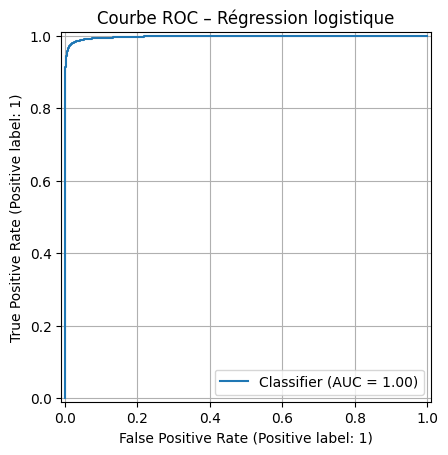

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay

# plt.figure(figsize=(6, 5))
# RocCurveDisplay.from_predictions(y_test, y_proba)
# plt.title("Courbe ROC – Régression logistique")
# plt.grid(True)
# plt.show()

# <font color="green">5 - Add Selected Features to Your Baseline Model</font>

Add calculated features into your baseline model. What is the performance if we use only the linguistic feature for our classification task? How to encode the features and add them to the existing word embedding?

<font color="red">5.1 Question:</font> Let's build a linear classifier using only the linguistic feature LSM. What are your best performance?  

List the tested linear classifier and their performance. Highlight the scenario that give best performance for each of them.

<font color="orange">5.1 Answer:</font> 

In [ ]:
# To-do

<font color="red">5.2 Question:</font> Try adding LSM to your baseline model. What is the nature of the calculated features (scaled, categorical, etc.)? How do you add them to the existing word embedding vector?

<font color="orange">5.2 Answer:</font> 

In [ ]:
# To-do

<font color="red">5.3 Question:</font> After adding LSM to your baseline model, are there any changes in the model's performance? How do you interpret the result? 

<font color="orange">5.3 Answer:</font> 

In [ ]:
# To-do

# <font color="green">**6 - Highlight Your Findings**</font>
This is an open question. Anything that stands out in your analysis should be highlighted. It could be a significant trend, an anomaly, or a correlation that was unexpected. Use visual aids like graphs or charts to make these findings clear and impactful.